# **Using Maching Learning to Forecast Energy Consumption**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

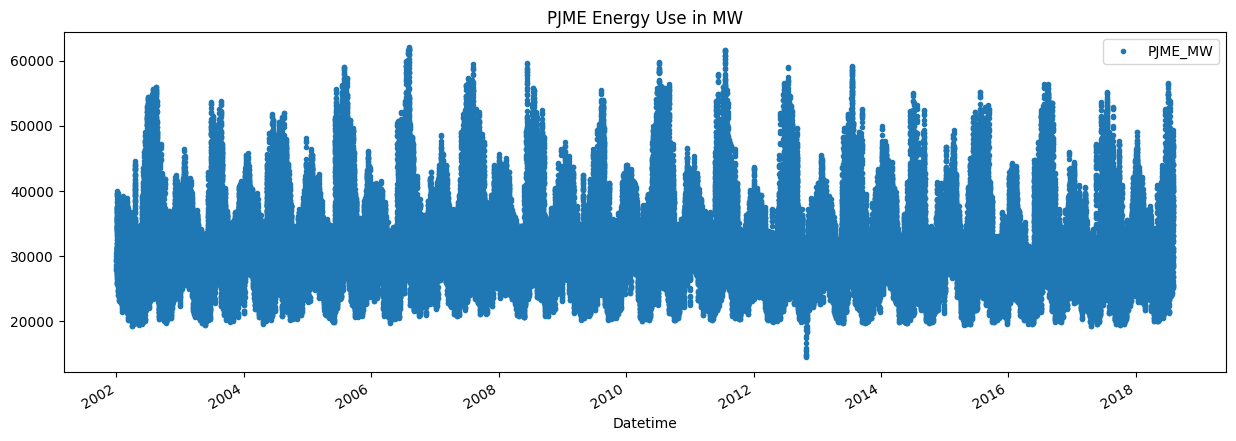

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [5]:
df.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# **TRAIN / TEST Split and Data Visualization**

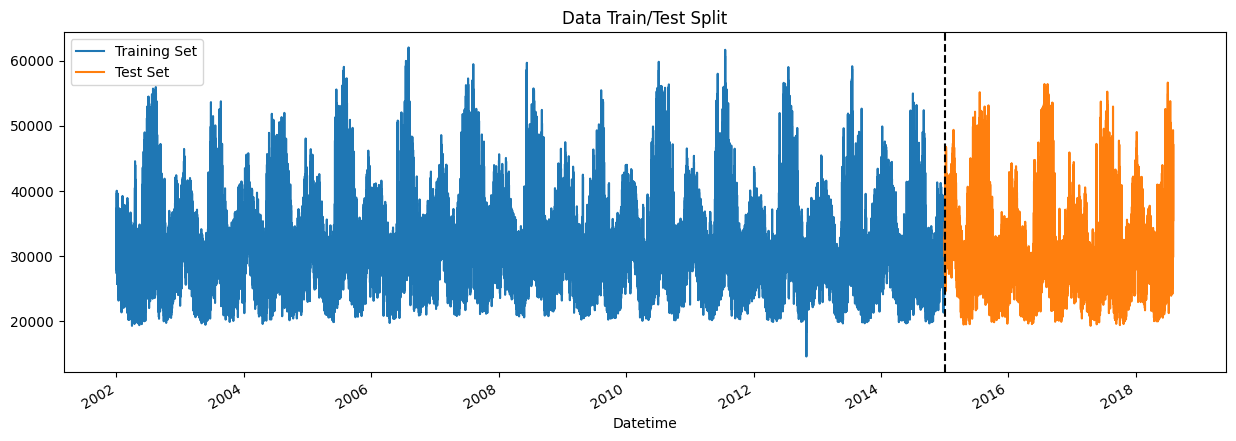

In [6]:
#Splitting the data into train and test Set
train_data = df.loc[df.index < '01-01-2015']
test_data = df.loc[df.index >= '01-01-2015']


#Plotting the train and Test Set
fig, ax = plt.subplots(figsize=(15,5))
train_data.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data.plot(ax=ax, label='Test Set',color=color_pal[1])
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Show Data for one week

<AxesSubplot: title={'center': 'Week Of Data'}, xlabel='Datetime'>

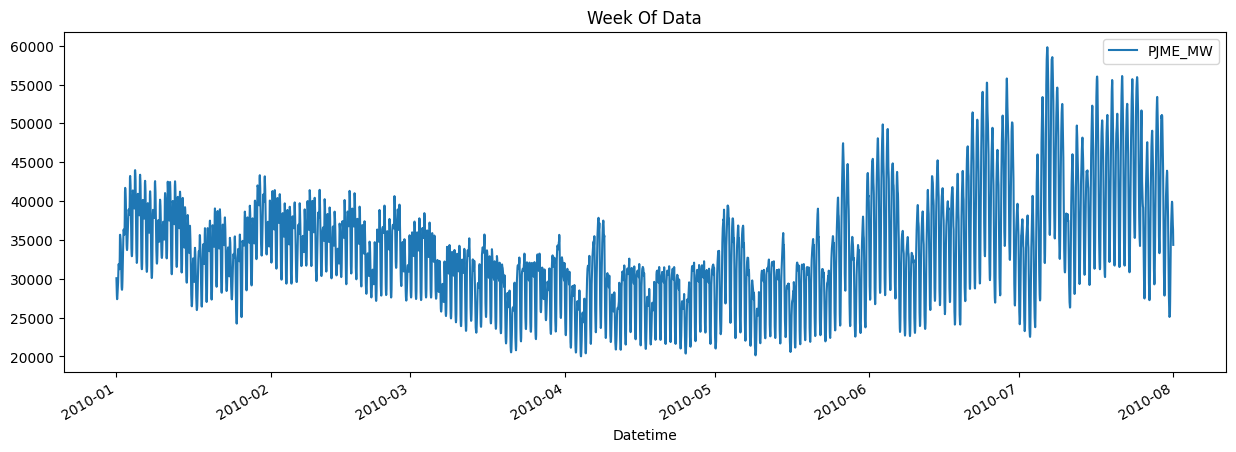

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '08-01-2010')].plot(figsize=(15, 5), title='Week Of Data')

# **Feature Creation**

In [8]:
#Splitting the Datetime into difefrent features .

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [9]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


# **Visualization of Features/Target Relationship**

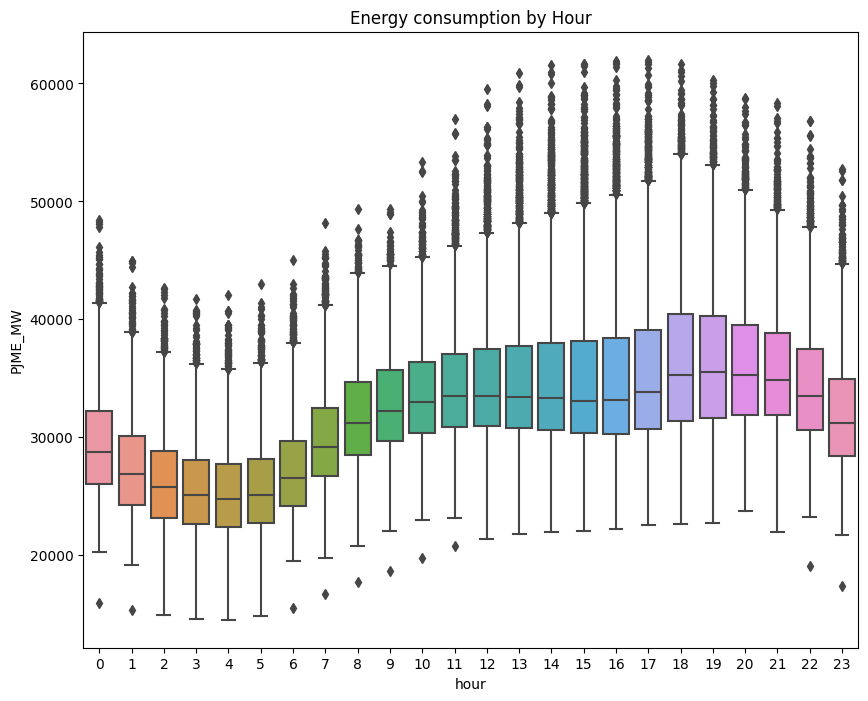

In [10]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Energy consumption by Hour')
plt.show()

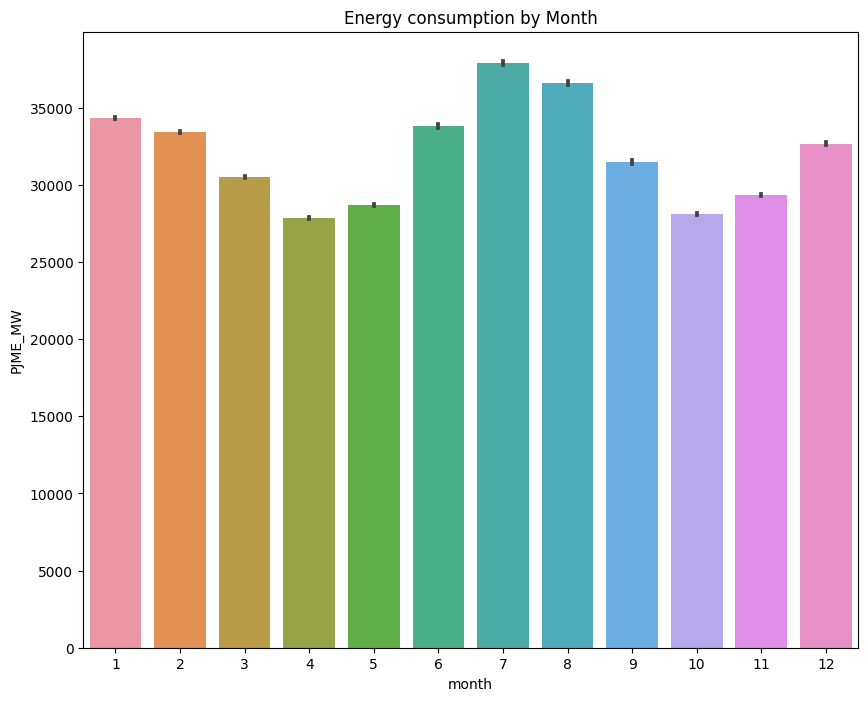

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=df, x='month', y='PJME_MW')
ax.set_title('Energy consumption by Month')
plt.show()

# **Train The Model**

In [12]:
#Create the features of test and train data
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

# Adding Verbose = 100 will show traing and validation scores in every 100 trees.
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[01:48:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# **Feature Importance**

Feature importance is used to get an overview of the impact of each features used to train our model

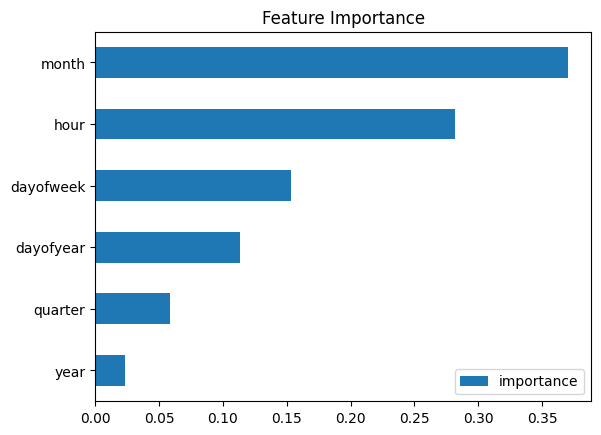

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# **Forecast of the Test Set**

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
print(test['prediction'])
df = df.merge(test[['prediction']])
df

Datetime
2015-01-01 00:00:00    30527.794922
2015-12-31 01:00:00    28238.072266
2015-12-31 02:00:00    27310.228516
2015-12-31 03:00:00    26884.867188
2015-12-31 04:00:00    26884.867188
                           ...     
2018-01-01 20:00:00    36173.695312
2018-01-01 21:00:00    36114.289062
2018-01-01 22:00:00    34566.808594
2018-01-01 23:00:00    32367.011719
2018-01-02 00:00:00    31172.447266
Name: prediction, Length: 31440, dtype: float32


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
0,32802.0,0,3,1,1,2015,1,1,1,30527.794922
1,31647.0,1,3,1,1,2015,1,1,1,29436.337891
2,30755.0,2,3,1,1,2015,1,1,1,28510.337891
3,30189.0,3,3,1,1,2015,1,1,1,28084.974609
4,29890.0,4,3,1,1,2015,1,1,1,28026.650391
...,...,...,...,...,...,...,...,...,...,...
363233,35770.0,14,6,3,7,2018,210,29,30,37136.648438
363234,37250.0,15,6,3,7,2018,210,29,30,37136.648438
363235,37250.0,15,6,3,7,2018,210,29,30,37136.648438
363236,38637.0,16,6,3,7,2018,210,29,30,37208.207031


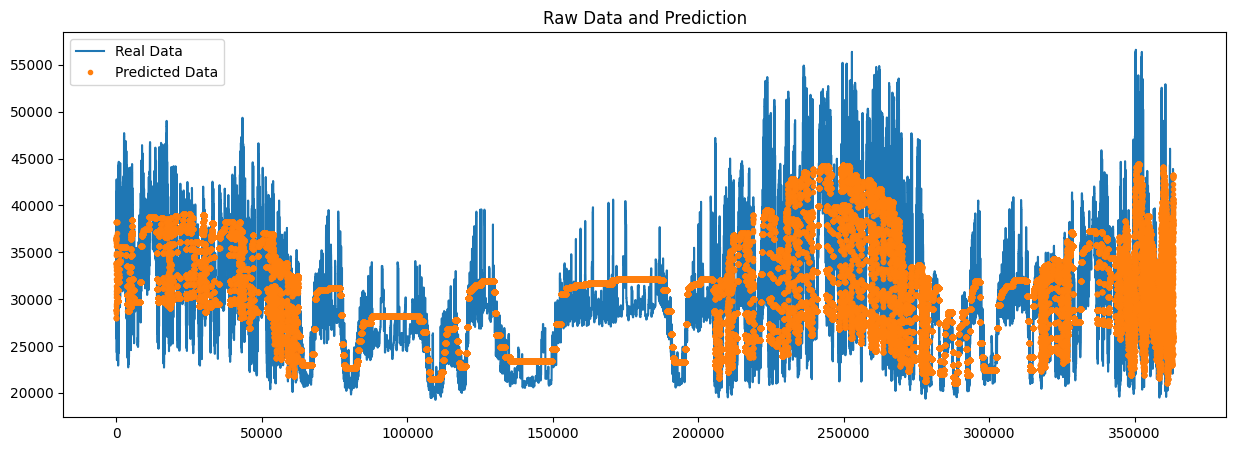

In [16]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predicted Data'])
ax.set_title('Raw Data and Prediction')
plt.show()

# **Calculating RMSE Score**

In [17]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75
